# Simple Visualizations

Let's now use the tidied data to create some simple figures over the aggregated data. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("tidied_nhl.csv")

# Comparing Shot Types and Goal Conversion for a Selected Season

We will use a stacked bar chart to show the distribution of different shot types (e.g., wrist shot, slapshot) across all teams for a chosen season (in our case, it is the 2016-17 season). Overlaying goals on top of shots in the same chart will allow us to easily compare the effectiveness of the different shot types.

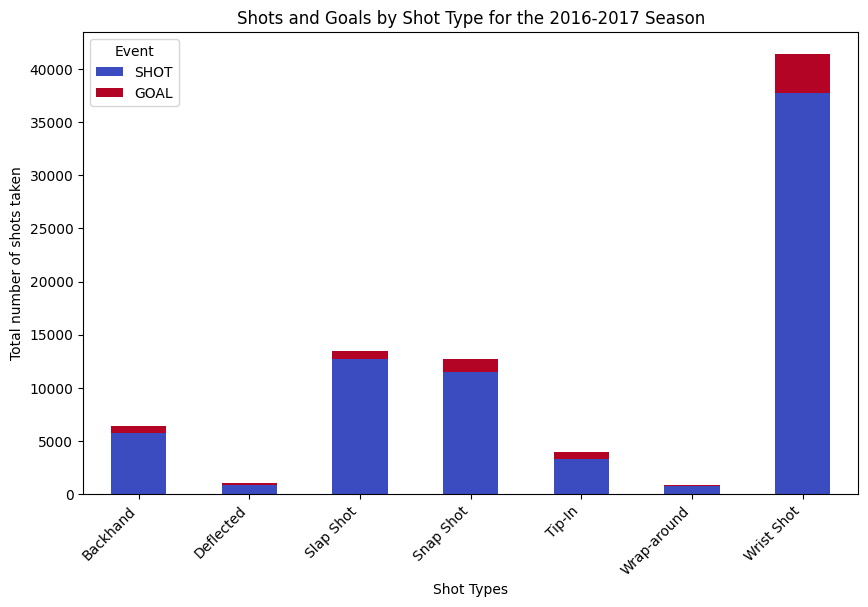

In [3]:
# Select a season
season = '2016-2017'

# Select only the rows of the chosen season
season_df = df[df['Season'] == season]

shot_data = season_df.groupby(['ShotType', 'Event']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = shot_data[['SHOT', 'GOAL']].plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))

plt.title(f'Shots and Goals by Shot Type for the {season} Season')
plt.xlabel('Shot Types')
plt.ylabel('Total number of shots taken')
plt.legend(title='Event')
plt.xticks(rotation=45, ha='right')
plt.show()

# Relationship Between Shot Distance and Goal Probability From the 2018-19 to 2020-21 Seasons

We will create line plots with shot distance on the x-axis and the chance of a goal (goal probability) on the y-axis for each season from 2018-19 to 2020-21. We will do one figure per season and one figure of all 3 seasons together in order to view the differences between the seasons more easily.

In [4]:
# Calculates the distance between a shot/goal and the net, rounded to the nearest number
# the column 'distance_to_goal' is added to the df
def distance(df: pd.DataFrame) -> pd.DataFrame:
    right_goal = [89, 0]
    left_goal = [-89, 0]

    distance_to_goal = np.zeros(df.shape[0])
    for i, row in df.iterrows():
    
        if row['RinkSide'] == 'right':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - left_goal[0])**2 + (row['YCoord'] - left_goal[1])**2).round()
        
        elif row['RinkSide'] == 'left':
            distance_to_goal[i] = np.sqrt((row['XCoord'] - right_goal[0])**2 + (row['YCoord'] - right_goal[1])**2).round()
    
        else:
            distance_to_goal[i] = None  # some games didn't have the information for which side the team was defending

    # add the column with its values
    df['distance_to_goal'] = distance_to_goal
    return df


In [5]:
# Creates multiple graphs (one for each desired season) with one line plot
def plot_shot_goal_ratio(seasons: [str]):
    for i, season in enumerate(seasons):
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])

        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)

        # Plot the line graph
        plt.figure(figsize=(10, 6))
        plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=s)
        plt.title(f'Shot-to-Goal Ratio vs. Distance to Goal for {season} season')
        plt.xlabel('Distance to Goal (in feet)')
        plt.ylabel('Shot-to-Goal Ratio')
        plt.grid(True)
        plt.show()


In [6]:
# Creates single graph with one line plot figure for each the desired season
def plot_shot_goal_ratio_full(seasons: [str]):
    # Graph for all seasons together
    plt.figure(figsize=(10, 6))

    # Create a list to store individual line plots
    line_plots = []

    for season in seasons:
        s = season.split("-")[0]  # assuming that the input will always be the format "yyyy-yyyy"
        season_df = df[df['GameID'].astype(str).str.startswith(s)]
        shot_season_df = season_df[season_df['GameID'].astype(str).str.startswith(s)]
        shot_season_df.reset_index(inplace=True)
        shot_season_df = distance(shot_season_df)
        result_df = shot_season_df.groupby('distance_to_goal').agg(
            shots=('Event', lambda x: (x == 'SHOT').sum()),
            goals=('Event', lambda x: (x == 'GOAL').sum())
        )
        # Calculate shot_goal_ratio
        result_df['shot_goal_ratio'] = result_df['goals'] / (result_df['shots'] + result_df['goals'])
    
        # Reset the index to get a clean DataFrame
        result_df.reset_index(inplace=True)
    
        # Create individual line plots for each season
        line_plot, = plt.plot(result_df['distance_to_goal'], result_df['shot_goal_ratio'], label=f'Season {season}')
        line_plots.append(line_plot)

    # Create a legend for the final combined graph
    plt.legend(handles=line_plots, loc='upper right')
    
    plt.title('Shot-to-Goal Ratio vs. Distance to Goal from the 2018-19 to 2020-21 seasons')
    plt.xlabel('Distance to Goal (in feet)')
    plt.ylabel('Shot-to-Goal Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()



In [7]:
# Select list of seasons to plot
seasons = ['2018-2019', '2019-2020', '2020-2021']

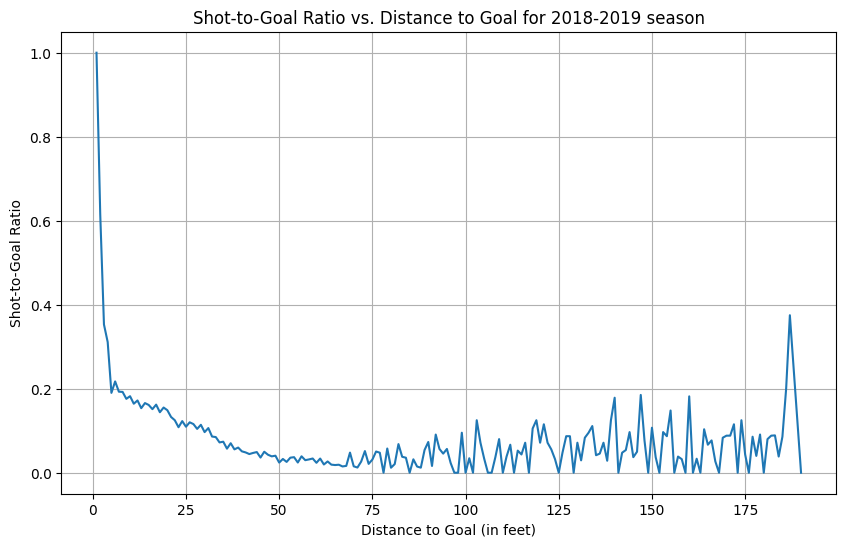

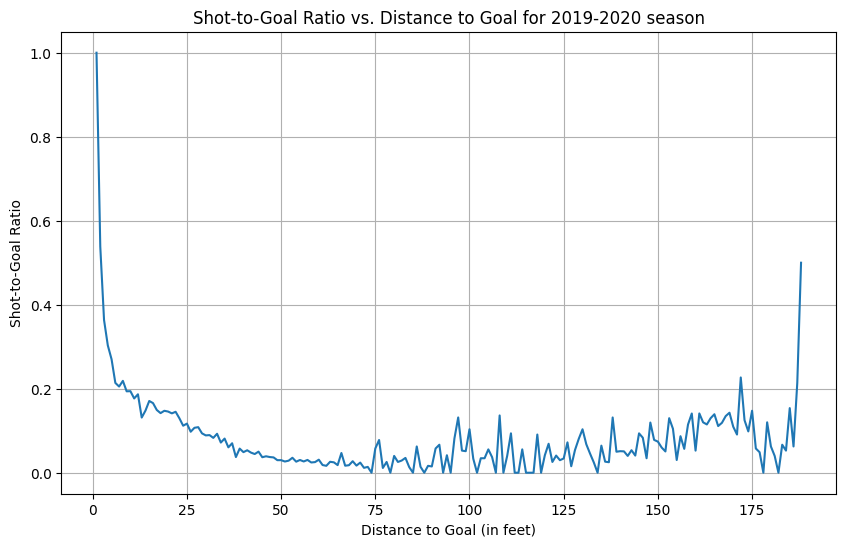

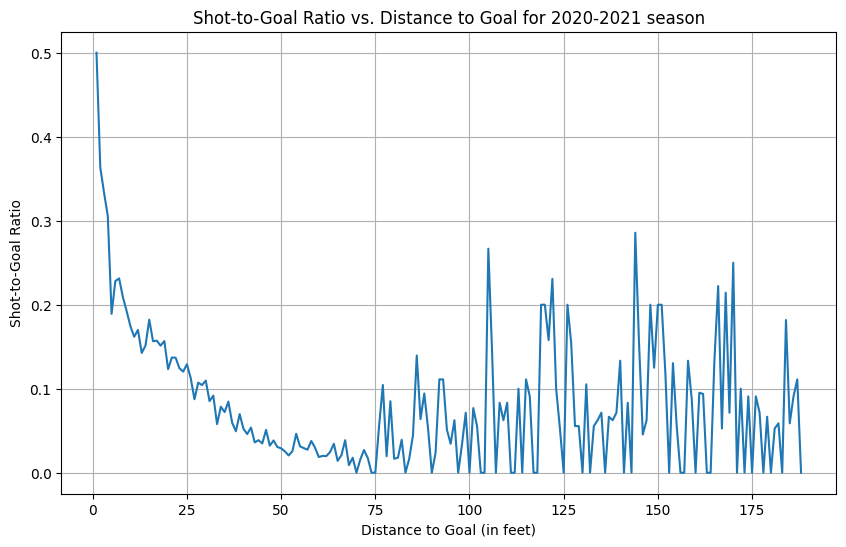

In [8]:
# plot the individual graphs
plot_shot_goal_ratio(seasons)

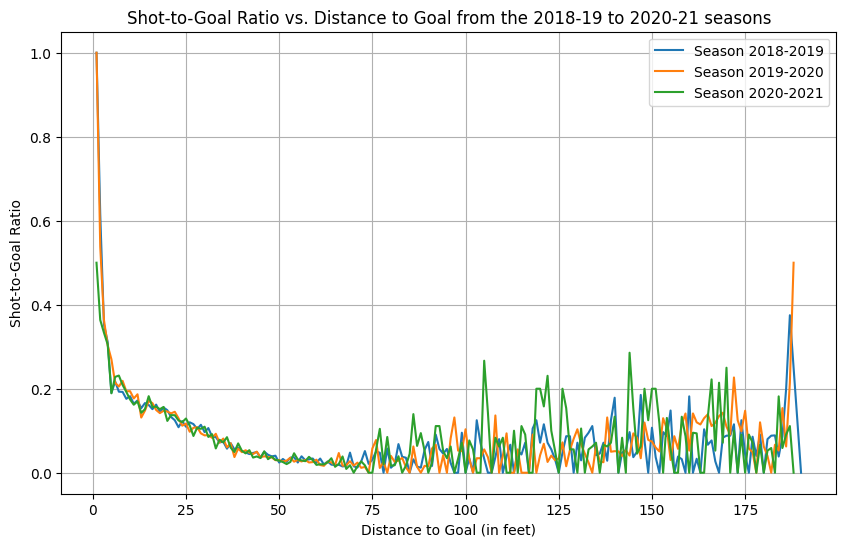

In [9]:
# plot the single graph with multiple line plots
plot_shot_goal_ratio_full(seasons)

# Goal Percentage by Shot Type and Distance for the 2016-17 Season

We will use a heatmap where the x-axis represents shot distance from the net, the y-axis represents different shot types (e.g., wrist shot, slapshot). The color intensity in each cell represents the goal percentage (# goals / # shots) for that combination of shot type and distance. Darker colors indicate higher goal percentages, while lighter colors indicate lower goal percentages.